In [2]:
using Pkg
Pkg.activate("..")
using Revise,DataFrames,PythonPlot,Statistics
PythonPlot.svg(true)
using SizeStructuredPopulations
using SpecialFunctions

methods(generate_cell)

  Activating project at `~/Dartmouth College Dropbox/Ethan Levien/RESEARCH/ACTIVE/SizeStructuredPopulations`


# 1 method for generic function "generate_cell" from SizeStructuredPopulations:
 [1] generate_cell(model::GrowthModel, init::Vector{Float64}, Tmax::Float64; dt)
     @ ~/Dartmouth College Dropbox/Ethan Levien/RESEARCH/ACTIVE/SizeStructuredPopulations/src/model.jl:26

In [3]:
λ(x) = 1.0 + max(0.1*sum(x),-0.9)
α = 0.5
σY = 0.2

# division distribution
function β(x, z, t)
    y0 = z[1]- z[2]
    μ = log(2) - α * y0
    A = exp(-((z[1] - μ)^2) / (2 * σY^2))/(2 * π * σY^2)^(1/2)
    B = (1 - erf((z[1] - μ) / (sqrt(2) * σY)))
    return  λ(x)*A / B
end

# symmetric division 
h(z, x) = ([z[1] - log(2),0],x)

# OU process dynamics of x
L(x, t, dt) = -1 .*x*dt .+ sqrt(dt) .*randn(3)

model = GrowthModel(λ, β, h, L)
init = vcat([0.0], [0.0, 0.0], zeros(3))
model

GrowthModel(Main.λ, Main.β, Main.h, Main.L)

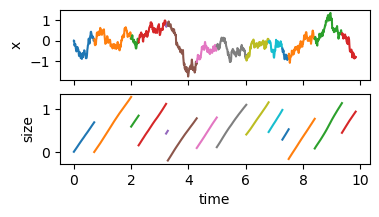

In [88]:
cell = generate_cell(model, init,10.0,dt = 0.01);
root = simulate_lineage(model, 10., init, dt = 0.01);
df = lineage_to_dataframe(root);

fig, axs = subplots(figsize=(4,2),nrows=2,sharex=true)


ax = axs[0]

data = root
while data.daughterL !== nothing
    ax.plot(data.time,[x[1] for x in data.x])
    data = data.daughterL
end
ax.set_ylabel("x")

ax = axs[1]

data = root
while data.daughterL !== nothing
    ax.plot(data.time,[z[1] for z in data.z])
    data = data.daughterL
end

ax.set_xlabel("time")
ax.set_ylabel("size")
fig

In [89]:
Td = 1.0
Tmax = 7.0
function terminate(cell)
    return cell.time[end] > Tmax 
end
cell = generate_cell(model, init,10.0,dt = 0.01);
grow_tree!(cell,model,terminate)

In [90]:
function make_branches(root::Cell,dt)
    branches = Vector{Tuple{Float64, Float64, Float64, Float64}}()

    function traverse(cell::Cell, x0::Float64, y0::Float64, depth::Int)
        # Compute vertical branch (lifespan)
        dt_life = (cell.time[end] - cell.time[1])
        y1 = y0 - dt_life
        push!(branches, (x0, y0, x0, y1))
        
        dx = 2.0^(-depth)

        # Horizontal links to daughters
        y_daughter = y1  # All daughters start at y1

        # Check for daughters
        if cell.daughterL !== nothing 
            # DaughterL
            xL = x0 - dx
            push!(branches, (x0, y1, xL, y_daughter))
            traverse(cell.daughterL, xL, y_daughter, depth + 1)
        end
        if cell.daughterR !== nothing
            # DaughterR
            xR = x0 + dx
            push!(branches, (x0, y1, xR, y_daughter))
            traverse(cell.daughterR, xR, y_daughter, depth + 1)
        end
    end

    traverse(root, 0.0, 0.0, 2)
    return branches
end


function population_to_dataframe(root::Cell)
    rows = []

    function traverse(cell::Cell, branch::String)
        n = length(cell.time)
        d = length(cell.x[1])
        for i in 1:n
            row = (
                time = cell.time[i],
                z1 = cell.z[i][1],
                z2 = cell.z[i][2],
                x = cell.x[i],
                branch = branch,
            )
            push!(rows, row)
        end
        if cell.daughterL !== nothing
            traverse(cell.daughterL, branch * "0")
        end
        if cell.daughterR !== nothing
            traverse(cell.daughterR, branch * "1")
        end
    end

    traverse(root, "")
    df = DataFrame(rows)

    # Expand `x` vector into individual columns
    d = length(df.x[1])
    for j in 1:d
        df[!, "x$j"] = getindex.(df.x, j)
    end
    select!(df, Not(:x))  # remove the original `x` column

    return df
end

population_to_dataframe (generic function with 1 method)

In [ ]:
branches = make_branches(cell, 0.1)
fig, ax = subplots(figsize=(10,4))
for (x0, y0, x1, y1) in branches
    ax.plot([x0, x1], [y0, y1], color="black",lw=0.5)
end
fig


In [81]:
df = population_to_dataframe(cell)
df = df[df.time .< Tmax,:]

Row,time,z1,z2,branch,x1,x2,x3
,Float64,Float64,Float64,String,Float64,Float64,Float64
1,0.0,0.0,0.0,,0.0,0.0,0.0
2,0.01,0.01,0.01,,-0.0815087,-0.00187724,-0.00822642
3,0.02,0.0199084,0.0199084,,0.0610339,-0.0181588,-0.160937
4,0.03,0.0297903,0.0297903,,0.110686,0.0152907,-0.293383
5,0.04,0.0396229,0.0396229,,0.0464596,0.154779,-0.391936
6,0.05,0.0494322,0.0494322,,-0.126668,-0.134056,-0.325175
7,0.06,0.0588463,0.0588463,,0.0848746,-0.169129,-0.391866
8,0.07,0.0683702,0.0683702,,-0.0768363,-0.107712,-0.308304
9,0.08,0.0778774,0.0778774,,0.136055,-0.148181,-0.437881


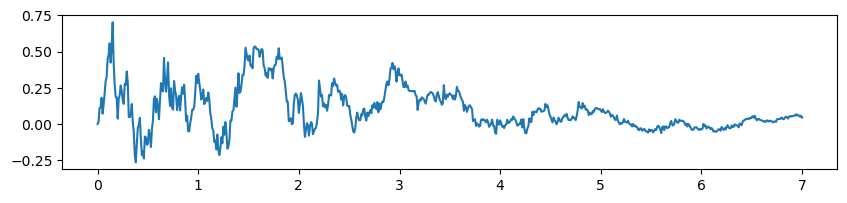

In [66]:
dfavg = combine(groupby(df,:time),:x1 => mean => :x1)
fig,ax = subplots(figsize=(10,2))
ax.plot(dfavg.time,dfavg.x1)
fig

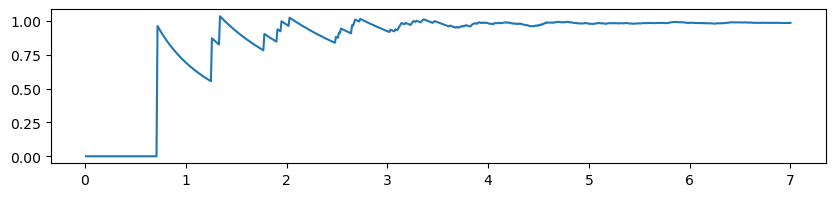

In [85]:
dfavg = combine(groupby(df,:time),:branch => length => :n)
fig,ax = subplots(figsize=(10,2))
ax.plot(dfavg.time,log.(dfavg.n) ./ dfavg.time)
fig